In [ ]:
import pandas as pd
import numpy as np
from copy import deepcopy as dc
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import random
import datetime
from torch.optim import Adam,AdamW
from torch.optim import RMSprop

Dataset Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Path to Toronto Data
toronto_path = ["/content/drive/MyDrive/RBC_LSI/dataset/toronto-occupancy*.csv",
                "/content/drive/MyDrive/RBC_LSI/dataset/toronto-weather*.csv",
                "/content/drive/MyDrive/RBC_LSI/dataset/toronto-inflation*.csv",
                "/content/drive/MyDrive/RBC_LSI/dataset/toronto-unemployment*.csv",
                "/content/drive/MyDrive/RBC_LSI/dataset/toronto-cpi*.csv"]

calgary_path = ["../dataset/calgary-occupancy*.csv",
                "../dataset/calgary-weather*.csv",
                "../dataset/calgary-inflation*.csv",
                "../dataset/calgary-unemployment*.csv",
                "../dataset/calgary-cpi*.csv"]


In [ ]:
from datetime import datetime
import pandas as pd

def read_dataframe(path: str):
    """Load a CSV into a DataFrame, printing its row-count on success.

    Returns
    -------
    pd.DataFrame | None
        The loaded data, or None when the file can’t be opened / parsed.
    """
    try:
        data_df = pd.read_csv(path, header=0, low_memory=False,
                              encoding="unicode_escape")
        print(f"{path}: loaded {len(data_df)} rows")
        return data_df
    except FileNotFoundError:
        print(f"[!] File not found → {path}")
    except Exception as err:
        print(f"[!] Failed reading CSV: {err}")
    return None


def standardize_date(text: str):
    """Convert many date formats to `datetime.date` (or `pd.NaT` on error)."""
    try:
        if len(text) == 8 and "-" in text:          # e.g. "24-05-18"
            return datetime.strptime(text, "%y-%m-%d").date()
        return pd.to_datetime(text).date()          # let pandas do the rest
    except Exception:
        return pd.NaT


In [ ]:
import glob
import pandas as pd

# constant defined once, outside the function
CITY_PATHS = {
    "calgary": calgary_path,
    "toronto": toronto_path,
}

def assemble_city_dataset(city: str):
    """
    Build the full daily dataset (plus per-shelter frames for Toronto) for
    the chosen city and return `(master_df, shelter_frames_dict)`.
    """
    p_group = CITY_PATHS[city]

    occ_files, wx_files = (glob.glob(p) for p in p_group[:2])
    infl_fp, unemp_fp, cpi_fp = (glob.glob(p)[0] for p in p_group[2:])

    # --- occupancy ---
    occ_list = [read_dataframe(f) for f in occ_files]
    occ_list = [
        df.drop(columns=[
            '_id','SHELTER_ID','LOCATION_ID','LOCATION_CITY','LOCATION_PROVINCE',
            'PROGRAM_NAME','PROGRAM_AREA','SERVICE_USER_COUNT','CAPACITY_FUNDING_BED',
            'UNOCCUPIED_BEDS','UNAVAILABLE_BEDS','CAPACITY_FUNDING_ROOM',
            'UNOCCUPIED_ROOMS','UNAVAILABLE_ROOMS'
        ]).assign(
            OCCUPANCY_DATE=pd.to_datetime(
                df['OCCUPANCY_DATE'].astype(str).map(standardize_date))
        )
        for df in occ_list
    ]
    occ_df = pd.concat(occ_list, ignore_index=True)

    max_d, min_d = occ_df['OCCUPANCY_DATE'].max(), occ_df['OCCUPANCY_DATE'].min()
    day_index = pd.date_range(min_d, max_d, freq='D').to_frame(index=False,
                                                               name='OCCUPANCY_DATE')

    # --- weather ---
    wx_list = [read_dataframe(f) for f in wx_files]
    wx_list = [
        df.drop(columns=[
            'ï»¿"Longitude (x)"','Latitude (y)','Station Name','Climate ID','Year',
            'Month','Day','Data Quality','Max Temp Flag','Min Temp Flag',
            'Mean Temp Flag','Heat Deg Days Flag','Cool Deg Days Flag',
            'Total Rain (mm)','Total Rain Flag','Total Snow (cm)','Total Snow Flag',
            'Total Precip Flag','Snow on Grnd Flag','Dir of Max Gust (10s deg)',
            'Dir of Max Gust Flag','Spd of Max Gust (km/h)','Spd of Max Gust Flag'
        ]).assign(
            OCCUPANCY_DATE=pd.to_datetime(df['Date/Time'])
        )
        for df in wx_list
    ]
    wx_df = (
        pd.concat(wx_list, ignore_index=True)
          .query("@min_d <= OCCUPANCY_DATE <= @max_d")
          .fillna(0)
          .rename(columns={"OCCUPANCY_DATE": "OCCUPANCY_DATE"})
    )

    # --- inflation ---
    infl_df = read_dataframe(infl_fp).rename(
        columns=lambda c: ("OCCUPANCY_DATE" if c == infl_fp.columns[0] else
                           "INFLATION_RATE_CHANGE")
    )
    day_index['YEAR_MONTH'] = day_index['OCCUPANCY_DATE'].dt.to_period('M')
    if city == "calgary":
        infl_df['OCCUPANCY_DATE'] = pd.to_datetime(
            infl_df.iloc[:, 0], format="%y-%b", errors='coerce')
        infl_df['YEAR_MONTH'] = infl_df['OCCUPANCY_DATE'].dt.to_period('M')
        infl_df = (
            infl_df.query("@min_d <= OCCUPANCY_DATE <= @max_d")
                   .drop(columns='OCCUPANCY_DATE')
        )
        infl_df = pd.merge(day_index, infl_df, on='YEAR_MONTH', how='left')
    else:
        infl_df['OCCUPANCY_DATE'] = pd.to_datetime(infl_df['OCCUPANCY_DATE'])
        infl_df = infl_df.query("OCCUPANCY_DATE <= @max_d")
        infl_df = (
            pd.merge(infl_df, day_index, on='OCCUPANCY_DATE', how='outer')
              .sort_values('OCCUPANCY_DATE')
              .ffill()
        )
    infl_df = infl_df.drop(columns='YEAR_MONTH')

    # --- unemployment ---
    un_df = read_dataframe(unemp_fp).rename(
        columns={unemp_fp.columns[0]: 'OCCUPANCY_DATE'}
    )
    if city == "calgary":
        un_df = un_df.rename(columns={un_df.columns[1]: 'UNEMPLOYMENT_RATE'})
    else:
        un_df = (
            un_df.drop(columns=[
                'Labour force 7','Employment 8','Unemployment 9','Population 6',
                'Participation rate 11','Employment rate 12'
            ]).rename(columns={un_df.columns[1]: 'UNEMPLOYMENT_RATE'})
        )
    un_df['OCCUPANCY_DATE'] = pd.to_datetime(un_df['OCCUPANCY_DATE'],
                                             format="%y-%b", errors='coerce')
    un_df['YEAR_MONTH'] = un_df['OCCUPANCY_DATE'].dt.to_period('M')
    un_df = un_df.query("@min_d <= OCCUPANCY_DATE <= @max_d") \
                 .drop(columns='OCCUPANCY_DATE')
    un_df = pd.merge(day_index, un_df, on='YEAR_MONTH', how='left') \
               .drop(columns='YEAR_MONTH')

    # --- CPI ---
    cpi_df = (
        read_dataframe(cpi_fp)[['ï»¿"REF_DATE"', 'Products and product groups', 'VALUE']]
          .rename(columns={
              'ï»¿"REF_DATE"': 'OCCUPANCY_DATE',
              'Products and product groups': 'CPI_TYPE',
              'VALUE': 'CPI_VALUE'
          })
          .query('CPI_TYPE == "All-items"')
          .drop(columns='CPI_TYPE')
    )
    cpi_df['OCCUPANCY_DATE'] = pd.to_datetime(cpi_df['OCCUPANCY_DATE'])
    cpi_df['YEAR_MONTH'] = cpi_df['OCCUPANCY_DATE'].dt.to_period('M')
    cpi_df = cpi_df.query("@min_d <= OCCUPANCY_DATE <= @max_d") \
                   .drop(columns='OCCUPANCY_DATE')
    cpi_df = pd.merge(day_index, cpi_df, on='YEAR_MONTH', how='left') \
                .drop(columns='YEAR_MONTH')

    # --- merge everything ---
    master = (occ_df.merge(wx_df, on='OCCUPANCY_DATE', how='left')
                     .merge(infl_df, on='OCCUPANCY_DATE', how='left')
                     .merge(un_df,  on='OCCUPANCY_DATE', how='left')
                     .merge(cpi_df, on='OCCUPANCY_DATE', how='left')
                     .sort_values('OCCUPANCY_DATE'))

    shelter_frames = {}
    if city == "toronto":
        bed = master.pop('OCCUPANCY_RATE_BEDS')
        room = master.pop('OCCUPANCY_RATE_ROOMS')
        master['OCCUPANCY_RATE_BEDS'] = bed
        master['OCCUPANCY_RATE_ROOMS'] = room

        for pid, grp in master.groupby('PROGRAM_ID'):
            grp = grp.copy()
            grp['OCCUPANCY_DATE'] = pd.to_datetime(grp['OCCUPANCY_DATE'])
            shelter_frames[pid] = grp

        master.reset_index(drop=True, inplace=True)
        master.to_csv("univariate_data.csv", index=False)

    return master, shelter_frames


In [ ]:
dataframe, iso_data = loadData("toronto")
print(dataframe)

Number of rows in the dataFrame: /content/drive/MyDrive/RBC_LSI/dataset/toronto-occupancy-2025.csv 13610
Number of rows in the dataFrame: /content/drive/MyDrive/RBC_LSI/dataset/toronto-occupancy-2024.csv 48794
Number of rows in the dataFrame: /content/drive/MyDrive/RBC_LSI/dataset/toronto-occupancy-2021.csv 50944
Number of rows in the dataFrame: /content/drive/MyDrive/RBC_LSI/dataset/toronto-occupancy-2022.csv 49478
Number of rows in the dataFrame: /content/drive/MyDrive/RBC_LSI/dataset/toronto-occupancy-2023.csv 48345
       OCCUPANCY_DATE  ORGANIZATION_ID         ORGANIZATION_NAME  \
0          2025-01-01               24  COSTI Immigrant Services   
1          2025-01-01               24  COSTI Immigrant Services   
2          2025-01-01               24  COSTI Immigrant Services   
3          2025-01-01               24  COSTI Immigrant Services   
4          2025-01-01               24  COSTI Immigrant Services   
...               ...              ...                       ...   

In [ ]:
def aggregate_shelter_daily(shelter_df: pd.DataFrame) -> pd.DataFrame:
    """Return one-row-per-day totals with overall occupancy %."""
    to_remove = [
        'ORGANIZATION_NAME', 'SHELTER_GROUP', 'LOCATION_NAME', 'SECTOR',
        'ORGANIZATION_ID', 'PROGRAM_MODEL', 'OVERNIGHT_SERVICE_TYPE',
        'LOCATION_ADDRESS', 'LOCATION_POSTAL_CODE', 'PROGRAM_ID',
        'CAPACITY_TYPE', 'OCCUPANCY_RATE_BEDS', 'OCCUPANCY_RATE_ROOMS'
    ]
    slim = shelter_df.drop(columns=to_remove)

    cap_tot = slim.groupby('OCCUPANCY_DATE')[['CAPACITY_ACTUAL_BED',
                                              'CAPACITY_ACTUAL_ROOM']].sum()
    occ_tot = slim.groupby('OCCUPANCY_DATE')[['OCCUPIED_BEDS',
                                              'OCCUPIED_ROOMS']].sum()

    slim = (
        slim.merge(cap_tot, on='OCCUPANCY_DATE', suffixes=('', '_CAP'))
            .merge(occ_tot, on='OCCUPANCY_DATE', suffixes=('', '_OCC'))
            .drop(columns=['CAPACITY_ACTUAL_BED', 'CAPACITY_ACTUAL_ROOM',
                           'OCCUPIED_BEDS', 'OCCUPIED_ROOMS'])
            .drop_duplicates()
    )

    slim['OCCUPANCY_PCT'] = 100 * (
        slim['OCCUPIED_BEDS_OCC'] + slim['OCCUPIED_ROOMS_OCC']
    ) / (
        slim['CAPACITY_ACTUAL_BED_CAP'] + slim['CAPACITY_ACTUAL_ROOM_CAP']
    )

    return slim.drop(columns=[
        'CAPACITY_ACTUAL_BED_CAP', 'CAPACITY_ACTUAL_ROOM_CAP',
        'OCCUPIED_BEDS_OCC', 'OCCUPIED_ROOMS_OCC'
    ])


In [ ]:
daily_totals = aggregate_shelter_daily(dataframe)
print(daily_totals)


       OCCUPANCY_DATE  Max Temp (Â°C)  Min Temp (Â°C)  Mean Temp (Â°C)  \
0          2023-01-01             5.0             2.7              3.9   
136        2023-01-02             5.6             3.5              4.6   
272        2023-01-03             4.4             2.8              3.6   
408        2023-01-04             4.4             2.5              3.5   
544        2023-01-05             4.8             3.2              4.0   
...               ...             ...             ...              ...   
110030     2025-03-28             3.9             1.4              2.6   
110174     2025-03-29             2.3            -0.1              1.1   
110318     2025-03-30             6.6             0.3              3.4   
110462     2025-03-31            10.9             1.3              6.1   
110605     2025-04-01             4.5            -0.7              1.9   

        Heat Deg Days (Â°C)  Cool Deg Days (Â°C)  Total Precip (mm)  \
0                      14.1             

Convert dataset to dataloader

In [ ]:
def get_scaler():
    scaler = MinMaxScaler(feature_range = (-1, 1))
    return scaler

In [ ]:
used_features = ['OCCUPANCY_DATE', 'OCCUPIED_PERCENTAGE']
df = df[used_features]

print(df)

       OCCUPANCY_DATE  OCCUPIED_PERCENTAGE
0          2023-01-01            99.103995
136        2023-01-02            99.015574
272        2023-01-03            98.900616
408        2023-01-04            99.105834
544        2023-01-05            99.018746
...               ...                  ...
110030     2025-03-28            98.132698
110174     2025-03-29            98.255583
110318     2025-03-30            98.411858
110462     2025-03-31            98.388600
110605     2025-04-01            98.270777

[822 rows x 2 columns]


In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [ ]:
def time_series_converter(iso_data, scaler, n_past, n_future, train_test_split, batch_size, used_features, shel_group = None):

    train_x = []
    train_y = []

    if shel_group is not None:

        one_hot_len = max(shel_group.values()) + 1

        num_feat = len(used_features) - 1 + one_hot_len

        dfs = []

        #Iterate through all useable Shelters
        for i in shel_group:

            #Getting the df from Iso Data
            df = iso_data[int(i)]

            #Unifying the df to have the same output column name
            if df['OCCUPANCY_RATE_ROOMS'].isna().all():
                df = df.rename(columns = {'OCCUPANCY_RATE_BEDS': 'OCCUPIED_PERCENTAGE'})
            else:
                df = df.rename(columns = {'OCCUPANCY_RATE_ROOMS': 'OCCUPIED_PERCENTAGE'})

            df = df[used_features]

            for z in range(one_hot_len):
                if shel_group[i] == z:
                    df['Feature_' + str(z)] = 1
                else:
                    df['Feature_' + str(z)] = 0

            dfs.append(df)

            #Concatenating all Dfs together
            concatenated_df = pd.concat(dfs, ignore_index=True)

            #Isolate the feature columns
            iso_col = concatenated_df[['Feature_' + str(i) for i in range(one_hot_len)]]

            #Scaled the dfs
            scaler = scaler.fit(concatenated_df[used_features[1:]])
            np_df = scaler.fit_transform(concatenated_df[used_features[1:]])
            df_scaled = pd.DataFrame(np_df, columns=used_features[1:])

            #Combined the final df together
            np_df = pd.concat([iso_col, df_scaled], axis=1).values

    else:
        df = dc(iso_data)
        df.set_index('OCCUPANCY_DATE', inplace=True)
        df = df.astype(float)
        scaler = scaler.fit(df)

        np_df = scaler.transform(df)

        num_feat = len([i for i in df])

    #Converting it into a time series
    for i in range(n_past, len(np_df) - n_future + 1):
        train_x.append(np_df[i - n_past: i, 0:np_df.shape[1]])
        train_y.append(np_df[i: i + n_future, - 1])

    train_x, train_y = np.array(train_x), np.array(train_y)

    split_index = int(len(train_x) * train_test_split)

    X_train = train_x[:split_index]
    X_test = train_x[split_index:]

    Y_train = train_y[:split_index]
    Y_test = train_y[split_index:]

    X_train_ = X_train.reshape((-1, n_past, num_feat))
    X_test_ = X_test.reshape((-1, n_past, num_feat))

    X_train = torch.tensor(X_train).float()
    Y_train = torch.tensor(Y_train).float()
    X_test = torch.tensor(X_test).float()
    Y_test = torch.tensor(Y_test).float()

    train_Dataset = TimeSeriesDataset(X_train, Y_train)
    test_Dataset = TimeSeriesDataset(X_test, Y_test)

    train_loader = DataLoader(train_Dataset, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_Dataset, batch_size = batch_size, shuffle = False)

    return train_loader, test_loader

In [ ]:
n_steps = 7
n_future = 1
batch_size = 16
train_test_split = 0.75
scaler = get_scaler()

In [ ]:
train_loader, test_loader = time_series_converter(df, scaler, n_steps, n_future, train_test_split, batch_size, used_features)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # Define the LSTM layers
        self.lstm_layers = nn.ModuleList([nn.LSTM(input_size, hidden_size, batch_first=True)])
        for _ in range(1, num_stacked_layers):
            self.lstm_layers.append(nn.LSTM(hidden_size, hidden_size, batch_first=True))

        # Define the fully connected layers
        self.fc_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size)])
        self.fc_layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        batch_size = x.size(0)
        out = x

        # Initialize hidden state and cell state tensors for each LSTM layer
        hidden_states = [torch.zeros(1, batch_size, self.hidden_size) for _ in range(self.num_stacked_layers)]
        cell_states = [torch.zeros(1, batch_size, self.hidden_size) for _ in range(self.num_stacked_layers)]

        # Pass input through each LSTM layer
        for lstm_layer, h0, c0 in zip(self.lstm_layers, hidden_states, cell_states):
            out, _ = lstm_layer(out, (h0, c0))

        # Apply fully connected layers
        out = self.fc_layers[0](out[:, -1, :])  # Apply the first fully connected layer
        out = torch.relu(out)  # Apply ReLU activation function
        for fc_layer in self.fc_layers[1:]:
            out = fc_layer(out)

        return out

In [ ]:
learning_rate = 1e-3
num_epochs = 30
train_test_split = 0.75
loss_function = nn.MSELoss()
input_size = 1
hidden_size = 460
num_stacked_layers = 3
output_size = 1

In [ ]:
model = LSTM(input_size, hidden_size, num_stacked_layers, output_size)
optimizer = AdamW(model.parameters(), lr=learning_rate)

In [ ]:
def train_model(net, epochs, train_dl, valid_dl, criterion, opt):
    """Train `net` and return (model, train_loss_hist, val_loss_hist, val_avg_hist)."""
    train_hist, val_hist, val_avg = [], [], []

    for ep in range(epochs):
        # ---- training phase ----
        net.train()
        ep_loss = 0.0
        if ep % 5 == 0:
            print(f"Epoch {ep}")

        for xb, yb in train_dl:
            pred = net(xb)
            loss = criterion(pred, yb)
            ep_loss += loss.item()

            opt.zero_grad()
            loss.backward()
            opt.step()

        if ep % 5 == 0:
            print(f"train loss: {ep_loss:.4f}")

        train_hist.append(ep_loss)

        # ---- validation phase ----
        net.eval()
        v_loss = 0.0
        with torch.no_grad():
            for xb, yb in valid_dl:
                v_loss += criterion(net(xb), yb).item()

        val_hist.append(v_loss)
        mean_val = v_loss / len(valid_dl)
        val_avg.append(mean_val)

        if ep % 5 == 0:
            print(f"val loss: {mean_val:.4f}\n{'*'*40}\n")

    return net, train_hist, val_hist, val_avg


In [ ]:
model, training_loss, valid_loss, avg_valid_loss = begin_training(model, num_epochs, train_loader, test_loader, loss_function, optimizer)


Epoch: 0
Training Loss: 2.782673324458301
Val Loss: 0.314
***************************************************


Epoch: 5
Training Loss: 0.590818502008915
Val Loss: 0.086
***************************************************


Epoch: 10
Training Loss: 0.40913136024028063
Val Loss: 0.108
***************************************************


Epoch: 15
Training Loss: 0.39645073318388313
Val Loss: 0.138
***************************************************


Epoch: 20
Training Loss: 0.4471800746396184
Val Loss: 0.156
***************************************************


Epoch: 25
Training Loss: 0.41976209403946996
Val Loss: 0.193
***************************************************




In [ ]:
def plot_loss(train_hist, val_hist, val_avg):
    """Visualise training / validation loss history."""
    epochs = range(1, len(train_hist) + 1)
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    axes[0].plot(epochs, train_hist)
    axes[1].plot(epochs, val_hist)
    axes[2].plot(epochs, val_avg)

    axes[0].set_title("Training Loss")
    axes[1].set_title("Validation Loss")
    axes[2].set_title("Avg Validation Loss / Batch")

    for ax in axes:
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Error")

    plt.tight_layout()
    plt.show()


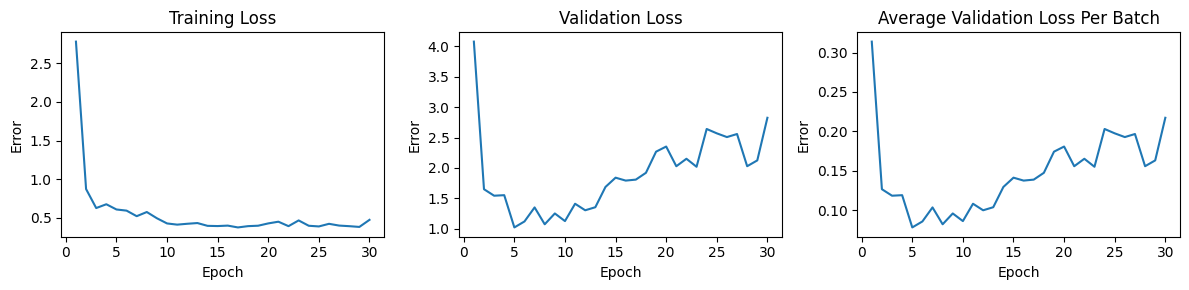

In [ ]:
plot_errors(training_loss, valid_loss, avg_valid_loss)

In [ ]:
import copy
import numpy as np
import torch
import pandas as pd

def forecast_series(net, data_df, scale_fn, step, days=None, one_hot=None):
    """
    Predict future occupancy percentages.

    Parameters
    ----------
    net : torch.nn.Module
        Trained model.
    data_df : pd.DataFrame
        Source data containing an OCCUPANCY_DATE column and features.
    scale_fn : sklearn-like scaler
        Must implement fit_transform / inverse_transform.
    step : int
        How many days the model forecasts per forward pass.
    days : int | None
        Total number of days to forecast when `step == 1`.
    one_hot : tuple[int, int] | None
        (index_of_active_class, total_classes) to prepend one-hot columns.

    Returns
    -------
    pd.DataFrame
        DataFrame with OCCUPANCY_DATE and OCCUPIED_PERCENTAGE for the horizon.
    """
    net.train(False)
    df_copy = copy.deepcopy(data_df)

    if step > 1:
        last = df_copy['OCCUPANCY_DATE'].max()
        horizon = pd.date_range(last, last + pd.Timedelta(days=step), freq='D')
        out_df = pd.DataFrame({'OCCUPANCY_DATE': horizon})

        df_copy = df_copy.set_index('OCCUPANCY_DATE')
        scaled = scale_fn.fit_transform(df_copy)

        if one_hot is not None:
            active, total = one_hot
            hot = np.eye(total)[[active] * scaled.shape[0]]
            scaled = np.hstack((hot, scaled))

        pred = net(torch.tensor(scaled).unsqueeze(0).float()).detach().numpy().reshape(-1, 1)
        tiled = np.repeat(pred, df_copy.shape[1], axis=1)
        inv = scale_fn.inverse_transform(tiled)[:, -1]
        inv = np.insert(inv, 0, data_df['OCCUPIED_PERCENTAGE'].iloc[-1])
        out_df['OCCUPIED_PERCENTAGE'] = inv

    else:  # step == 1  →  autoregressive loop
        series = data_df['OCCUPIED_PERCENTAGE'].to_numpy().reshape(-1, 1)
        seq = torch.tensor(scale_fn.fit_transform(series)
                           .reshape(-1, series.shape[0], 1)).float()

        for _ in range(days or 0):
            nxt = net(seq).unsqueeze(0)
            seq = torch.cat((seq, nxt), dim=1)

        inv = scale_fn.inverse_transform(seq.squeeze()
                                         .detach()
                                         .numpy()
                                         .reshape(-1, 1)).flatten()

        last = data_df['OCCUPANCY_DATE'].max()
        horizon = pd.date_range(last, last + pd.Timedelta(days=days or 0), freq='D')
        out_df = pd.DataFrame({'OCCUPANCY_DATE': horizon})

        new_vals = np.insert(inv[-(days or 0):], 0, data_df['OCCUPIED_PERCENTAGE'].iloc[-1])
        out_df['OCCUPIED_PERCENTAGE'] = new_vals

    return out_df


In [ ]:
import copy
import matplotlib.pyplot as plt
import pandas as pd

def plot_overview(net, data_df, step, scale_fn, test_view=False, days=None):
    """
    Compare actual vs. predicted occupancy rates on one figure.
    """
    df_view = copy.deepcopy(data_df)
    df_view['OCCUPANCY_DATE'] = pd.to_datetime(df_view['OCCUPANCY_DATE'])

    if test_view:
        back = step if days is None else days
        cutoff = df_view['OCCUPANCY_DATE'].max() - pd.Timedelta(days=back)
        df_view = df_view[df_view['OCCUPANCY_DATE'] <= cutoff]

    pred_df = forecast_series(net, df_view, scale_fn, step, days)

    plt.plot(data_df['OCCUPANCY_DATE'], data_df['OCCUPIED_PERCENTAGE'], label="Actual")
    plt.plot(pred_df['OCCUPANCY_DATE'], pred_df['OCCUPIED_PERCENTAGE'], label="Predicted")
    plt.title("All Shelters Occupancy Rates")
    plt.xlabel("Date")
    plt.ylabel("Occupied Percentage (%)")
    plt.legend()
    plt.show()


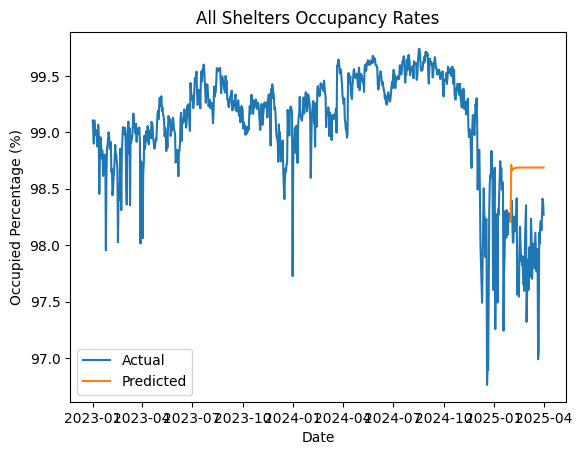

In [ ]:
test_view = True                # replaces test_check
data_df  = data_df[used_features]

plot_overview(
    net,            # ← your trained model variable
    data_df,        # ← DataFrame to plot
    step,           # ← what used to be n_future
    scale_fn,       # ← the scaler
    test_view,      # ← whether to roll the window back
    days=60         # ← future_days
)


In [ ]:
import copy
import random
import matplotlib.pyplot as plt
import pandas as pd

def plot_sample_shelters(net, iso_dict, step, grid, scale_fn,
                         feat_cols, test_view=False, days=None):
    """
    Draw `grid`×`grid` random shelter panels showing actual vs. predicted curves.
    """
    sel_keys = random.sample(list(iso_dict), grid ** 2)
    fig, axes = plt.subplots(grid, grid, figsize=(11, 8))

    for row in range(grid):
        for col in range(grid):
            key = sel_keys[row * grid + col]
            df_src = copy.deepcopy(iso_dict[key])

            if df_src['OCCUPANCY_RATE_ROOMS'].isna().all():
                df_src = df_src.rename(columns={'OCCUPANCY_RATE_BEDS': 'OCCUPIED_PERCENTAGE'})
            else:
                df_src = df_src.rename(columns={'OCCUPANCY_RATE_ROOMS': 'OCCUPIED_PERCENTAGE'})

            df_pred_in = df_src[feat_cols]

            if test_view:
                back = step if days is None else days
                cut = df_src['OCCUPANCY_DATE'].max() - pd.Timedelta(days=back)
                df_pred_in = df_pred_in[df_pred_in['OCCUPANCY_DATE'] <= cut]

            try:
                df_pred = forecast_series(net, df_pred_in, scale_fn, step, days)

                ax = axes[row, col]
                ax.plot(df_src['OCCUPANCY_DATE'], df_src['OCCUPIED_PERCENTAGE'])
                ax.plot(df_pred['OCCUPANCY_DATE'], df_pred['OCCUPIED_PERCENTAGE'])
                ax.set_title(f"Shelter {key}")
                ax.set_xlabel("Date")
                ax.set_ylabel("Occupied %")

            except Exception as err:
                print(f"[plot] skipped shelter {key}: {err}")

    plt.tight_layout()
    plt.show()


In [ ]:
# Drop shelters that don’t have enough rows for the chosen sequence length
for key in list(iso_dict):                  # iso_dict is your per-shelter dict
    if iso_dict[key].shape[0] < seq_len:    # seq_len replaces n_steps
        iso_dict.pop(key)


Error: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.


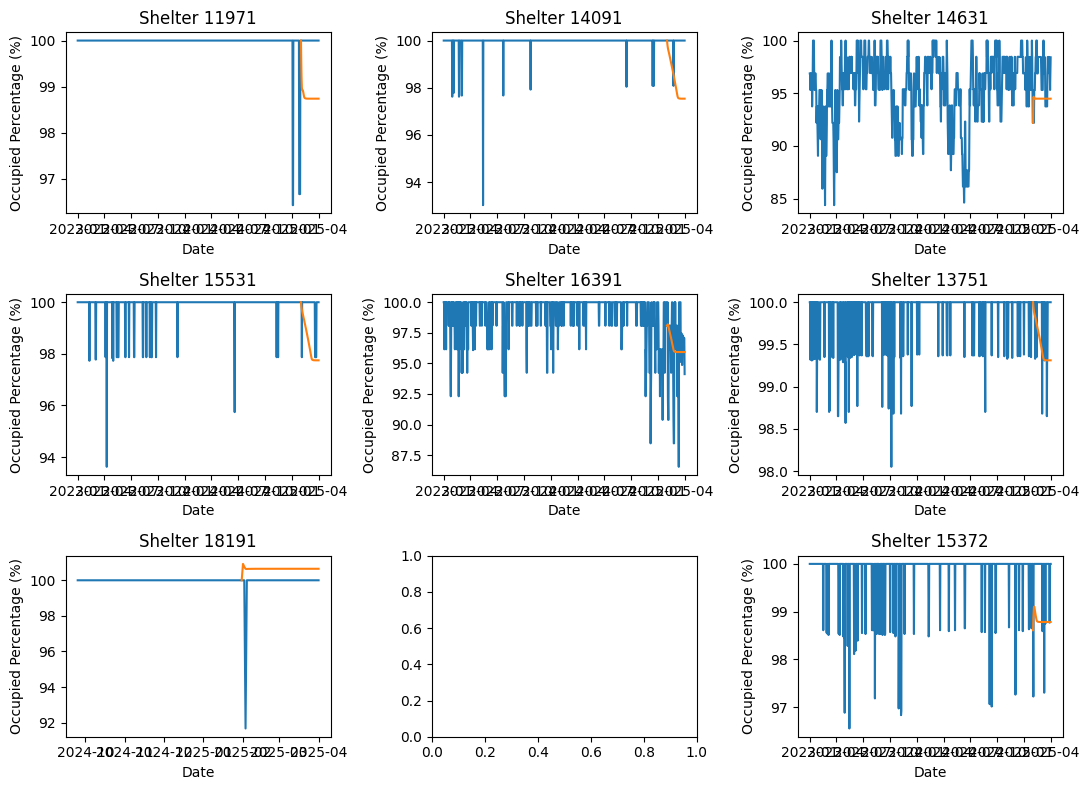

In [ ]:
test_view = True      # replaces test_check
grid      = 3         # replaces num_sq

plot_sample_shelters(
    net,              # your trained model (was “model”)
    iso_dict,         # per-shelter data dict (was “iso_data”)
    step,             # forecast horizon per pass (was “n_future”)
    grid,             # grid × grid panels to draw
    scale_fn,         # scaler (was “scaler”)
    feat_cols,        # list of feature columns (was “used_features”)
    test_view,        # whether to back-shift for testing
    days=60           # future_days
)


In [ ]:
import copy
import numpy as np
import pandas as pd

# ----- pick five shelters for hold-out testing -----
test_keys = [11794, 11831, 12252, 12254, 12274]
test_dict = {k: v for k, v in iso_dict.items() if k in test_keys}

# ----- loss accumulators -----
tot_mae, tot_rmse = 0.0, 0.0
cnt_mae, cnt_rmse = 0, 0

for key, frame in test_dict.items():
    if len(frame) <= 60:          # skip if not enough data
        continue

    df = frame.copy()

    # use whichever occupancy column is present
    if df['OCCUPANCY_RATE_ROOMS'].isna().all():
        df = df.rename(columns={'OCCUPANCY_RATE_BEDS': 'OCCUPIED_PERCENTAGE'})
    else:
        df = df.rename(columns={'OCCUPANCY_RATE_ROOMS': 'OCCUPIED_PERCENTAGE'})

    df = df[feat_cols]            # keep only the model’s feature columns

    cut = df['OCCUPANCY_DATE'].max() - pd.Timedelta(days=60)
    df_infer = df[df['OCCUPANCY_DATE'] <= cut]

    # predict next 60 days
    pred_df = forecast_series(net, df_infer, scale_fn, step, days=60)
    pred_df = pred_df[pred_df['OCCUPANCY_DATE'] > cut]

    true_df = df[df['OCCUPANCY_DATE'] > cut]

    y_true = true_df['OCCUPIED_PERCENTAGE'].to_numpy()
    y_pred = pred_df['OCCUPIED_PERCENTAGE'].to_numpy()

    mae  = np.abs(y_true - y_pred).mean()
    rmse = np.sqrt(((y_true - y_pred) ** 2).mean())

    tot_mae  += mae;   cnt_mae  += 1
    tot_rmse += rmse;  cnt_rmse += 1

avg_mae  = tot_mae  / cnt_mae
avg_rmse = tot_rmse / cnt_rmse

print(f"Average MAE per shelter:  {avg_mae:.3f}")
print(f"Average RMSE per shelter: {avg_rmse:.3f}")


Average Loss per shelter is 5.519734914143881
Average Root Mean Square Loss per shelter is 6.197977799976293
